# Import

In [12]:
import os
import re
import random
from IPython.display import clear_output

from ast import literal_eval
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Random Seeding

In [13]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

# Data Loading

In [14]:
# Load the train dataset
# TODO Train Data 경로 입력
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "../../../data/v0")
dataset = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)

# Short Paragraph Explore

## Paragraph Length Summary

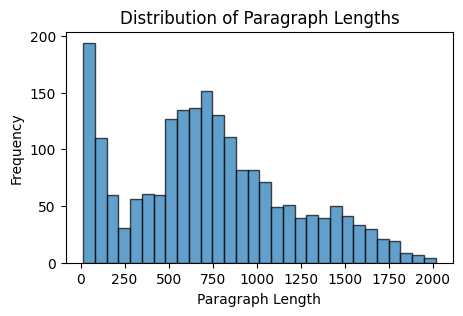

count    2031.000000
mean      735.324471
std       462.595621
min        15.000000
25%       407.500000
50%       699.000000
75%      1014.500000
max      2017.000000
Name: paragraph, dtype: float64

In [15]:
plt.figure(figsize=(5, 3))
plt.hist(df["paragraph"].apply(len), bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Paragraph Lengths')
plt.xlabel('Paragraph Length')
plt.ylabel('Frequency')
plt.show()

display(df["paragraph"].apply(len).describe())

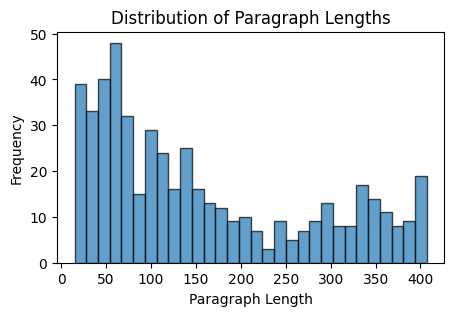

count    508.000000
mean     157.165354
std      119.025183
min       15.000000
25%       58.000000
50%      116.000000
75%      251.500000
max      407.000000
Name: paragraph, dtype: float64

In [16]:
less_than_q1 = df.loc[df["paragraph"].apply(len) <= 407.5, "paragraph"].apply(len)

plt.figure(figsize=(5, 3))
plt.hist(less_than_q1, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Paragraph Lengths')
plt.xlabel('Paragraph Length')
plt.ylabel('Frequency')
plt.show()

display(less_than_q1.describe())

## Manually Checking

In [17]:
from IPython.display import clear_output

index_for_shortP = df["paragraph"].apply(len) <= 50
for idx, row in df[index_for_shortP].iterrows():
    # index
    print("**ID**")
    print(row["id"])

    # paragraph
    paragraph = row["paragraph"].split(".")
    print("\n**지문**")
    print(*paragraph, sep="\n")

    # question
    print("\n**문제**")
    print(row["question"])

    # choices
    print("\n**선지**")
    print(*row["choices"], sep="\n")

    # answer
    print("\n**정답**")
    print(row["answer"])

    if input() == "stop":
        break

    clear_output(wait=True)

**ID**
generation-for-nlp-440

**지문**
(가) 도쿄에서 2․8 독립선언 발표 국내에서 6․10만 세 운동 발발

**문제**
(가) 시기에 있었던 사실로 옳은 것은?

**선지**
박상진 이 대한광복회를 조직하였다.
일제가 국가총동원법 을 적용하였다.
임병찬이 독립의 군부를 만들었다.
상하이에서 대한민국 임시정부가 수립되었다.

**정답**
4


KeyboardInterrupt: Interrupted by user

## Location for less than Q1 in data

In [ ]:
indices = less_than_q1.index
print(f"Indices Range : {min(indices)} to {max(indices)}\nTotal counts : {len(indices)}")

Indices Range : 0 to 790
Total counts : 508


# Check For Not-Understandable Text

## "밑줄 친"

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "Bllossom/llama-3.2-Korean-Bllossom-3B"
indices = df[df["question"].apply(lambda x : "밑줄 친 ‘그’" in x)].index
for idx in indices:
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(model_id)

    paragraph = df.loc[idx, "paragraph"]
    prompt = f"""당신은 글을 읽고, 저의 질문에 답해주셔야 합니다.
    지문:{paragraph}
    질문:지문에서 밑줄 친 그의 이름을 알려주세요.
    답변:"""

    tokenized = tokenizer(prompt, max_length=None, return_tensors="pt")
    model.eval()
    with torch.no_grad():
        outputs = model.generate(tokenized['input_ids'], max_new_tokens=5)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated_text)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


당신은 글을 읽고, 저의 질문에 답해주셔야 합니다.
    지문:이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다. …(중략) …소정방이 신라군이 늦게 왔다는 이유로 군문에서 신라 독군 김문영의 목을 베고자 하니, 그가 군사들 앞에 나아가 “황산 전투를 보지도 않고 늦게 온 것을 이유로 우리를 죄 주려 하는구나. 죄도 없이 치욕을 당할 수는 없으니, 결단코 먼저 당나라 군사와 결전을 한 후에 백제를 쳐야겠다.”라고 말하였다.
    질문:지문에서 밑줄 친 그의 이름을 알려주세요.
    답변:김문영. 



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


당신은 글을 읽고, 저의 질문에 답해주셔야 합니다.
    지문:그가 왕에게 아뢰었다. “삼교는 솥의 발과 같아서 하나라도 없어서는 안 됩니다. 지금 유교와 불교는 모두 흥하는 데도교는 아직 번성하지 않으니, 소위 천하의 도술(道術)을 갖추었다고 할 수 없습니다.엎드려 청하오니 당에 사신을 보내도교를 구해와서 나라 사람들을 가르치게 하소서.”－삼국사기－
    질문:지문에서 밑줄 친 그의 이름을 알려주세요.
    답변:지문에서 밑


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


당신은 글을 읽고, 저의 질문에 답해주셔야 합니다.
    지문:일제의 침략이 거세지자 그는 국외로 망명했다. 그는 의열단장 김원봉의 요청을 받아 ‘조선혁명 선언’을 작성하였다. 이 선언에는 외교운동에 주력하자는 주장에 반대하고 더욱 적극적인 독립운동을 추진하자는 내용이 담겨 있다.
    질문:지문에서 밑줄 친 그의 이름을 알려주세요.
    답변:김원봉. 



- "밑줄 친"이라는 표현을 그대로 쓰나, "등장한" 등으로 바꿔 쓰나 큰 차이는 없어 보임
- 다만 문제에서 "밑줄 친"이라는 표현을 쓰는 케이스가 3가지 밖에 없어서 많이 비교하지는 못함
- 지문 기준으로 "그"와 그의 이름이 포함된 데이터를 몇 개 추출하여 비교해볼 필요
- 반목문으로 돌릴 시, 이전의 시행했던 데이터와 관련된 메모리가 남아 있는건지 결과가 이상하게 나옴

# Problem Grouping

## Subject Classification

### Prompt Engineering

In [ ]:
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
transformers.logging.set_verbosity_error()

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "Bllossom/llama-3.2-Korean-Bllossom-3B"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

indices = random.sample(range(790), 200)
df_small = df.loc[indices]

generated_texts = []
for idx, row in tqdm(df_small.iterrows()):
    text = row["paragraph"].replace("\n", " ") + " " + row["question"].replace("\n", " ")
    prompt = f"""
    1. 당신은 주어진 지문을 읽고 해당 지문이 역사, 경제, 정치, 지리, 심리 중 어떤 분야의 문장인지 분류해야 합니다.

    2. 분류 하는 과정은 다음과 같습니다.
    - 예시 1
        지문:고종은 연호를 ‘광무’로 바꾸고 환구단을 세워 이곳에서 황제로 즉위하였으며 나라 이름을 (가)으로/로 선포하고 자주 독립 국가임을 알렸다.
        질문:해당 지문은 역사, 경제, 정치, 지리, 심리 중 어떤 분야의 지문인가요?
        답변:이 지문은 고종의 황제 즉위 등 역사적인 사건을 다루고 있습니다. 따라서, "역사"입니다.
    - 예시 2
        지문:대통령이 임기 마지막 2년을 앞두고 있음, 국제적 위기의 횟수와 심각성이 증가하고 있음, 의회와 백악관을 지배하는 정당이 서로 다름, 경제가 탄탄하고 대통령의 지지율이 높음
        질문:해당 지문은 역사, 경제, 정치, 지리, 심리 중 어떤 분야의 지문인가요?
        답변:대통령의 임기, 지지율 등 정치와 관련된 내용을 다루고 있습니다. 따라서, "정치"입니다.
    - 예시 3
        지문:가이아나, 수리남, 프랑스령 기아나의 공식 언어는 각각 영어, 네덜란드어, 프랑스어다. 이들 국가는 어느 대륙에 있는가?
        질문:해당 지문은 역사, 경제, 정치, 지리, 심리 중 어떤 분야의 지문인가요?
        답변:각 국가들의 위치에 대한 내용을 다루고 있습니다. 따라서, "지리"입니다.
    - 예시 4
        지문:I. 고정 금리 대출자 II. 고정 소득을 받는 개인 III. 고정 금리 저축자 IV. 식당 소유자 인플레이션으로 인해 피해를 입은 사람들 중에는 어떤 사람들이 포함되는가?
        질문:해당 지문은 역사, 경제, 정치, 지리, 심리 중 어떤 분야의 지문인가요?
        답변:고정 금리, 인플레이션 등 경제와 관련된 내용을 다루고 있습니다. 따라서, "경제"입니다.
    - 예시 5
        지문:에이브라함 매슬로우(Abraham Maslow)는 어떤 동기가 다른 동기보다 생존에 더 중요하다는 개념을 제안했습니다. 다음 접근 방식 중 에이브라함 매슬로우가 제안한 어떤 동기가 다른 동기보다 생존에 더 중요하다는 개념을 표현하는 것은 무엇입니까?
        질문:해당 지문은 역사, 경제, 정치, 지리, 심리 중 어떤 분야의 지문인가요?
        답변:생존에 대한 동기 등 인간 심리와 관련된 내용을 다루고 있습니다. 따라서, "심리"입니다.

    지문:{text}
    질문:해당 지문은 역사, 경제, 정치, 지리, 심리 중 어떤 분야의 지문인가요?
    답변:"""

    tokenized = tokenizer(prompt, max_length=None, return_tensors="pt")
    model.eval()
    with torch.no_grad():
        outputs = model.generate(tokenized['input_ids'].to(device), max_new_tokens=128)
    generated_text = tokenizer.decode(outputs[0].to("cpu"), skip_special_tokens=True)

    generated_texts.append(generated_text.split("\n")[27])

df_small["generated_text"] = generated_texts
df_small.to_csv("labeling_check.csv", index=False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

200it [14:44,  4.42s/it]


### Output Parsing

In [ ]:
def process_generated_text(text):
    try:
        return text.split("따라서").pop().split('"')[1]
    except IndexError:
        return None

df_small = pd.read_csv("labeling_check.csv")
generated_texts = df_small["generated_text"]

labels = generated_texts.apply(process_generated_text)
unlabeled_index = labels[labels.isnull()].index
for idx in unlabeled_index:
    print(generated_texts[idx])
    label = input()
    labels[idx] = label
    clear_output(wait=True)

df_small["label"] = labels

### Result

In [ ]:
df_small.groupby("label").count()["id"]

label
경제                        34
교육                         1
문화                         1
사회                        21
심리                        32
역사                        69
역사, 사회, 경제, 정치, 지리, 심리     1
정치                        32
지리                         9
Name: id, dtype: int64

In [ ]:
df_small.drop(index=26).groupby("label").count()["id"]

label
경제    34
교육     1
문화     1
사회    21
심리    32
역사    69
정치    32
지리     9
Name: id, dtype: int64

In [ ]:
tot = 0
cnt = 0
not_visible = []
for idx, row in df_small.iterrows():
    tot += 1
    # paragraph
    paragraph = row["paragraph"].split(".")
    print("\n**지문**")
    print(*paragraph, sep="\n")

    # question
    question = row["question"]
    print("\n**문제**")
    print(question)

    # answer
    label = row["label"]
    print("\n**분류**")
    print(label)

    command = input()
    if command == " ":
        cnt += 1
    elif command == "no":
        tot -= 1
        not_visible.append(idx)
    elif command == "stop":
        print(f"end at {idx}-th row")
        break

    clear_output(wait=True)
print(f"incorrect : {cnt}/{tot}({cnt/tot:.3f})")

incorrect : 36/200(0.180)


In [ ]:
print(f"incorrect : {cnt}/{tot-len(not_visible)}({cnt/tot:.3f})")

incorrect : 36/130(0.277)


# Length Camparision by Data Source

- ~ index-789 : KMMLU + MMMLU
- index-790 ~ : KLUE MRC
- KLUE MRC 쪽이 문맥 기반의 문제 풀이이므로, paragraph 길이가 길 것으로 생각됨

In [ ]:
MMLU = df.loc[:790]
MRC = df.loc[790:]

## MMLU

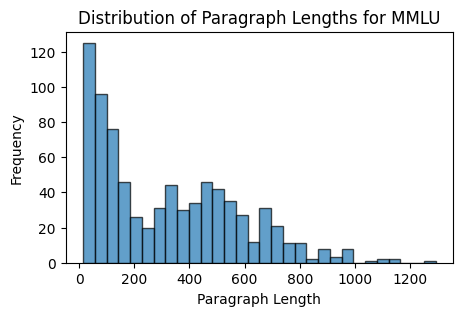

count     791.000000
mean      319.376738
std       255.671461
min        15.000000
25%        85.500000
50%       285.000000
75%       499.500000
max      1292.000000
Name: paragraph, dtype: float64

In [ ]:
plt.figure(figsize=(5, 3))
plt.hist(MMLU["paragraph"].apply(len), bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Paragraph Lengths for MMLU')
plt.xlabel('Paragraph Length')
plt.ylabel('Frequency')
plt.show()

display(MMLU["paragraph"].apply(len).describe())

## MRC

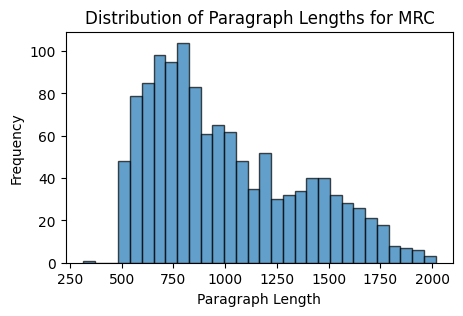

count    1241.000000
mean     1000.105560
std       358.185318
min       314.000000
25%       711.000000
50%       908.000000
75%      1252.000000
max      2017.000000
Name: paragraph, dtype: float64

In [ ]:
plt.figure(figsize=(5, 3))
plt.hist(MRC["paragraph"].apply(len), bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Paragraph Lengths for MRC')
plt.xlabel('Paragraph Length')
plt.ylabel('Frequency')
plt.show()

display(MRC["paragraph"].apply(len).describe())

# Click Dataset Load

In [22]:
data_id = "EunsuKim/CLIcK"
dataset = load_dataset(data_id)
dataset = pd.DataFrame(dataset["train"])

# choice: str to List[str] & answer: str to int
records = []
for _, row in dataset.iterrows():
    # remove label instruction text
    pattern = r'다음은 .+에 대한 문제이다\.\n'
    row["question"] = re.sub(pattern, "", row["question"])

    id = row["id"]
    paragraph = row["paragraph"] if len(row["paragraph"])!=0 else row["question"]
    question = row["question"]
    choices = row["choices"]
    answer = choices.index(row["answer"])+1
    records.append({
        'id': id,
        'paragraph': paragraph,
        'question': question,
        'choices': choices,
        'answer': answer,
    })
df = pd.DataFrame(records)

df.head()

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

,id,paragraph,question,choices,answer
0,KIIP_economy_1,한국이 외환위기를 완전히 극복한 년도는 언제인가?,한국이 외환위기를 완전히 극복한 년도는 언제인가?,"[1999년, 2000년, 2001년, 2002년]",3
1,KIIP_economy_2,1960년 한국의 1인당 국민총소득은 얼마였는가?,1960년 한국의 1인당 국민총소득은 얼마였는가?,"[79달러, 800달러, 8,000달러, 80,000달러]",1
2,KIIP_economy_3,한국이 외환위기를 겪은 년도는 언제인가?,한국이 외환위기를 겪은 년도는 언제인가?,"[1995년, 1996년, 1997년, 1998년]",3
3,KIIP_economy_4,한강은 어느 도시를 통과하는가?,한강은 어느 도시를 통과하는가?,"[부산, 대구, 인천, 서울]",4
4,KIIP_economy_5,1970년대부터 한국에서 발달하기 시작한 산업은 무엇인가?,1970년대부터 한국에서 발달하기 시작한 산업은 무엇인가?,"[농업, 경공업, 중화학 공업, 서비스 업]",3


In [23]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995 entries, 0 to 1994
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1995 non-null   object
 1   paragraph  1995 non-null   object
 2   question   1995 non-null   object
 3   choices    1995 non-null   object
 4   answer     1995 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 78.1+ KB


None

In [24]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
id           0
paragraph    0
question     0
choices      0
answer       0
dtype: int64


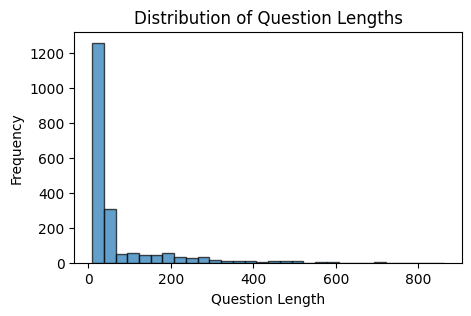

In [27]:
df['question_length'] = df['question'].apply(len)

plt.figure(figsize=(5, 3))
plt.hist(df['question_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

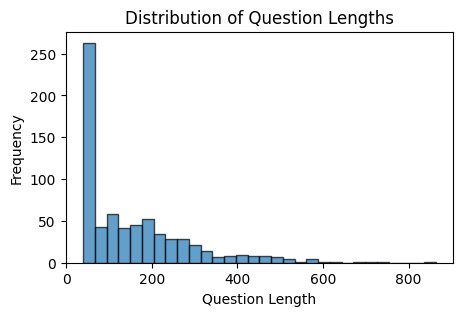

In [36]:
plt.figure(figsize=(5, 3))
plt.hist(df.loc[df['question_length'] >= 40, "question_length"], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

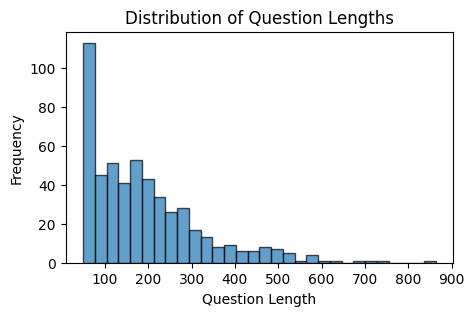

In [37]:
plt.figure(figsize=(5, 3))
plt.hist(df.loc[df['question_length'] >= 50, "question_length"], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()